In [195]:
# from __future__ import print_function
from __future__ import division

import json
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import gzip
from scipy.misc import imsave
import time
import scipy.ndimage

from keras import backend as K
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dropout

from keras.layers import *
from keras.layers.merge import concatenate
from keras.models import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, Callback
from keras import losses

from keras.preprocessing.image import ImageDataGenerator

from scipy.ndimage import morphology

import random
from itertools import islice

In [196]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"


In [4]:
cd ..

/home/malub_local/activelearningADS


## Utils

In [197]:
def preprocessor(input_img, img_rows, img_cols):
    """
    Resize input images to constants sizes
    :param input_img: numpy array of images
    :return: numpy array of preprocessed images
    """
    output_img = np.ndarray((input_img.shape[0], input_img.shape[1], img_rows, img_cols), dtype=np.uint8)
    
    for i in range(input_img.shape[0]):
        output_img[i, 0] = cv2.resize(input_img[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    
    return output_img


def load_data(path_img, path_mask, img_rows, img_cols):
    """
    Load data from project path
    :return: [X, y] numpy arrays containing the [training, validation, test] data and their respective masks.
    """
    print("\nLoading data...\n")
    X = np.load(path_img)
    y = np.load(path_mask)

    X = preprocessor(X, img_rows, img_cols)
    y = preprocessor(y, img_rows, img_cols)

    X = X.astype('float32')

    mean = np.mean(X)  # mean for data centering
    std = np.std(X)  # std for data normalization

    X -= mean
    X /= std

    y = y.astype('float32')
    y /= 255.  # scale masks to [0, 1]
    return X, y



#### loss and metrics #####
def dice_coef(y_true, y_pred, smooth = 1.):
    """Compute Dice Coefficient between prediction and Ground Truth
    :param y_true: ground truth
    :param y_pred: prediction
    :param smooth: avoid division by 0
    :return: dice coefficient
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)




def weighted_binary_crossentropy(y_true, y_pred):
    """Compute the weighted binary cross-entropy
    :param y_true: ground truth
    :param y_pred: prediction
    :return: weighted binary cross-entropy
    """
    b_ce = K.binary_crossentropy(y_true, y_pred)  # Calculate the binary crossentropy
    weight_vector = y_true * 0.30 + (1. - y_true) * 0.70  # Apply the weights
    weighted_b_ce = weight_vector * b_ce        
    return K.mean(weighted_b_ce) # Return the mean error


### data augmentation ######
def data_generator():
    """
    :return: Keras data generator. Data augmentation parameters.
    """
    return ImageDataGenerator(
        fill_mode = fill_mode,
        rotation_range = rotation_range,
        horizontal_flip = horizontal_flip,
        vertical_flip = vertical_flip,
        rescale = rescale,
        zoom_range = zoom_range,
        channel_shift_range = channel_shift_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range)
        #preprocessing_function = random_gaussian_noise)

def random_gaussian_noise(image):
    """Randomly apply gaussian noise to input image for data augmentation
    :param image: input image
    :return: noisy image
    """
    apply_gaussian_noise = random.choice([True, False])
    if apply_gaussian_noise == True:
        output_image = noisy(image)
    else:
        output_image = image
    return output_image
    

def noisy(image):
    """Apply gaussian noise to input image for data augmentation
    :param image: input image
    :return: noisy image
    """
    ch, row, col = image.shape
    mean = 0
    sigma = np.random.uniform(low=0.0, high=sigma_max, size=None)
    gauss = np.random.normal(mean, sigma, (ch, row,col))
    gauss = gauss.reshape(ch, row,col)
    noisy = image + gauss
    return noisy


def call(self, inputs, training=None):
    """Override Dropout. Make it able at test time
    """
    if 0. < self.rate < 1.:
        noise_shape = self._get_noise_shape(inputs)
        def dropped_inputs():
            return K.dropout(inputs, self.rate, noise_shape,
                             seed=self.seed)
        if (training):
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        else:
            return K.in_test_phase(dropped_inputs, inputs, training=None)
    return inputs


def reset_weights(model):
    """Initialize weights of Neural Networks
    """
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

            
            
def predict(data, model):
    """
    Data prediction for a given model
    :param data: input data to predict.
    :param model: unet model.
    :return: predictions.
    """
    return model.predict(data, verbose=0)

def compute_dice_coef(y_true, y_pred):
    """
    Computes the Dice-Coefficient of a prediction given its ground truth.
    :param y_true: Ground truth.
    :param y_pred: Prediction.
    :return: Dice-Coefficient value.
    """
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def compute_uncertain(sample, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param model: unet model with Dropout layers.
    :return: averaged-thresholded predictions after nb_steps_prediction samples
    :return: overall uncertainty (not map)
    :return: uncertainty_map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)
    # averaged-thresholded predictions after np_step_prediction predicted samples
    X_prediction = cv2.threshold(np.mean(X, axis=0), threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return np.sum(var * transform)

    else:
        return X_prediction, np.sum(np.var(X, axis=0)), np.var(X, axis=0)


def compute_uncertain_map(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: uncertainty map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return var * transform

    else:
        return np.var(X, axis=0)  

## Unet

In [198]:
def unet_full_bn(dropout):
    inputs = Input((1, img_rows, img_cols))
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)
    pool1 = Dropout(dropout_proba)(pool1)


    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
    pool2 = Dropout(dropout_proba)(pool2)

   
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
    pool3 = Dropout(dropout_proba)(pool3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    
    if dropout:
        pool4 = Dropout(dropout_proba)(pool4)
   
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(conv5)

    if dropout:
        conv5 = Dropout(dropout_proba)(conv5)    

    up6_interm = UpSampling2D(size=(2, 2))(conv5)
    
    up6 = concatenate([up6_interm, conv4], axis=1)

    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv6)
    batch6 = BatchNormalization(axis=1)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    
    if dropout:
        up7 = Dropout(dropout_proba)(up7)  
        
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(batch7), conv2], axis=1)
    up8 = Dropout(dropout_proba)(up8)

    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(batch8), conv1], axis=1)
    up9 = Dropout(dropout_proba)(up9)

    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(batch9)

    model = Model(outputs=conv10, inputs=inputs)

    model.compile(optimizer=Adam(lr = learning_rate, decay=decay_rate), loss=weighted_binary_crossentropy, 
                  metrics = [dice_coef])

    return model

In [199]:
def save_parameters(timestamp, params):
    """Save current parameters to text file
    :param timestamp:timestamp of the current run session
    :param params: dictionary of current parameters
    """
    param_file = str(param_path + 'params_' + timestamp + '.txt')
    txt_file = open(param_file,'w')
    txt_file.write(str(params))
    txt_file.close()
    
def get_params():
    """Convert list of current parameters to dictionary 
    """
    param_dict = {
    'img_rows':img_rows,
    'img_cols' : img_cols,
    'batch_size' : batch_size,
    'fill_mode' : fill_mode,
    'rotation_range': rotation_range,
    'horizontal_flip': horizontal_flip,
    'vertical_flip' : vertical_flip,
    'rescale' : rescale,
    'zoom_range': zoom_range,
    'channel_shift_range' : channel_shift_range,
    'width_shift_range' : width_shift_range,
    'height_shift_range' : height_shift_range,
    'nb_initial_epochs' : nb_initial_epochs,
    'apply_augmentation' : apply_augmentation,
    'nb_step_predictions': nb_step_predictions,
    'steps_per_epoch' : steps_per_epoch,
    'learning_rate' : learning_rate,
    'decay_rate' : decay_rate,
    'apply_edt' : apply_edt
    }
    return param_dict

## Score measure

In [200]:
## Score measure

def jaccard_score(y_pred, y_true):
    """Compute Jaccard Score (= Intersection / Union) between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Jaccard score value
    """
    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum() - intersection
    if union == 0:
        return 1.
    else:
        return float(intersection)/union
    
def pixel_wise_accuracy(y_true, y_pred):
    """Compute Pixel-wise accuracy (= number of well classified pixel / total number of pixel) 
    between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Pixel-wise accuracy value
    """
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    return 1 - np.count_nonzero(y_pred_f - y_true_f) / y_true_f.shape[1]
    

def distances(y_pred, y_true):
    d1 = morphology.distance_transform_edt(1- y_true) * y_pred
    d2 = morphology.distance_transform_edt(1 - y_pred) * y_true
    return d1, d2


def numeric_score(y_pred, y_true):
    """Compute True Positive, True Negative, False Positive, False Negative classifications
    between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: True Positive, True Negative, False Positive, False Negative
    """
    y_pred = y_pred.astype(int)
    y_true = y_true.astype(int)
    FP = float(np.sum((y_pred == 1) & (y_true == 0)))
    FN = float(np.sum((y_pred == 0) & (y_true == 1)))
    TP = float(np.sum((y_pred == 1) & (y_true == 1)))
    TN = float(np.sum((y_pred == 0) & (y_true == 0)))
    return FP, FN, TP, TN

def precision_score(y_pred, y_true):
    """Compute precision (= TP / (TP+FP)) between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Precision score value
    """
    FP, FN, TP, TN = numeric_score(y_pred, y_true)
    if (TP + FP) <= 0:
        return 0.
    else:
        return np.divide(TP, TP + FP) 
    

def sensitivity_score(y_pred, y_true):
    """Compute sensitivity (= TP / (TP+FN)) between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Sensitivity score value
    """
    FP, FN, TP, TN = numeric_score(y_pred, y_true)
    if (TP + FN) <= 0:
        return 0.
    else:
        return np.divide(TP, TP + FN) 



In [207]:
## Rank the most uncertain predictions

def to_be_annotated(uncertain, n):
    """Return index of the most n uncertain predictions"""
    return np.flip(np.argsort(uncertain), 0)[:n]

def add_annotated_sample(original, added, added_index):
    """append the annotated samples to the training set"""
    return np.vstack((original, added[added_index] ))


def remove_annotated(original, added_index):
    """remove annotated samples from unlabelled dataset"""
    new_index = np.delete(np.arange(len(original)), added_index)
    return original[new_index]

def random_index_generator(X_set, labelled_size, test_size):
    """Generate random index splits in labelled/unlabelled/test sets for active learning simulation
    :param X_set: initial dataset
    :param labelled_size: size of wished labelled set
    :param test_size: size of wished test set
    :return: labelled set index, unlabelled set index, test set index
    """
    unlabelled_size = len(X_set) - labelled_size - test_size
    index_labelled = np.random.choice(np.arange(len(X_set)), labelled_size, replace=False)
    index_unlabelled = np.setdiff1d(np.arange(len(X_set)), index_labelled)
    index_test = np.random.choice(index_unlabelled, test_size, replace=False)
    index_unlabelled = np.setdiff1d(index_unlabelled, index_test)
    return index_labelled, index_unlabelled, index_test

def data_splitting(X_set, labelled_size, test_size):
    unlabelled_size = len(X_set) - labelled_size - test_size
    index_labelled = np.arange(0, labelled_size, 1)
    index_unlabelled = np.arange(labelled_size, labelled_size + unlabelled_size, 1)
    index_test = np.arange(labelled_size + unlabelled_size, len(X_set), 1)
    return index_labelled, index_unlabelled, index_test

def random_train_valid_index_generator(data, ratio):
    train_size = int(len(data) * ratio)
    index_train = np.random.choice(np.arange(len(data)), train_size, replace=False)
    index_valid = np.setdiff1d(np.arange(len(data)), index_train)
    return index_train, index_valid

## Active Learing loop

In [202]:
def save_history(history, timestamp, iteration, history_path):
    """ Save training history in text file
    :param history: training history (numpy array)
    :param timestamp: timestamp of current run session
    :param iteration: active learning iteration number
    :param history_path: path to history text file
    """
    history_file = str(history_path + timestamp + '_history_iter_' +  str(iteration) +'_' + '.txt')
    txt_file = open(history_file,'w')
    txt_file.write(str(history))
    txt_file.close()
    
def scores(model, X_test, y_test, score_global):
    """Compute predictions scores on test set for the current active learning iteration
    :param model: trained Unet model
    :param X_test: test set
    :param y_test: test ground truth
    :param score global: numpy array with previous scores
    :return: numpy array with scores
    """
    uncertain_map = []
    uncertain = np.zeros(len(X_test))
    dice = np.zeros(len(X_test))
    jaccard = np.zeros(len(X_test))
    accuracy = np.zeros(len(X_test))
    sensitivity = np.zeros(len(X_test))
    precision = np.zeros(len(X_test))
    
    print("Computing predictions ...\n")
    predictions = predict(X_test, model)

    for i in range(len(X_test)):
        sample = X_test[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        dice[i] = compute_dice_coef(y_test[i][0], sample_prediction)
        jaccard[i] = jaccard_score(sample_prediction, y_test[i][0, :, :])
        accuracy[i] = pixel_wise_accuracy(sample_prediction, y_test[i][0, :, :])
        sensitivity[i] = sensitivity_score(sample_prediction, y_test[i][0, :, :])
        precision[i] = precision_score(sample_prediction, y_test[i][0, :, :])
        _ , uncertain[i], uncertain_map_i = compute_uncertain(sample, model)
        #uncertain_map_i = compute_uncertain_map(sample, sample_prediction, model)
        uncertain_map.append(uncertain_map_i)

    uncertain_map_array = np.asarray(uncertain_map)
    print(uncertain_map_array.shape)
    print("Done computing predictions")

    metrics_array = np.array([np.mean(dice), np.mean(jaccard), np.mean(accuracy), np.mean(precision),
                                np.mean(sensitivity)])
    score_global = np.vstack((score_global, metrics_array))
    
    return score_global


def balance_uncertainty(sample_pred, uncertainty):
    """Multiply uncertainty by a ratio to overcome unbalanced class issues
    :param sample_pred: prediction for a sample
    :param uncertainty: associated uncertainty measure
    :return: scaled uncertainty measure
    """
    ratio = (0.5 / ((np.count_nonzero(sample_pred)+1.0) / (512*512* 1.0)))
    return uncertainty*ratio


def uncertainty_for_ranking(model, X_set):
    """Compute uncertainty and uncertainty map for a set of images
    :param model: trained Unet model
    :param X_set: set of data
    :return: numpy array with uncertainty value and numpy array of uncertainty maps for each image of X_set
    """
    # uncertainty computation for unlabelled
    print("Computing predictions for unlabelled data ...\n")
    uncertain_map = []
    uncertainty = np.zeros(len(X_set))
    predictions = predict(X_set, model)
    X = []
    for i in range(len(X_set)):
        sample = X_set[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        X_i, uncertainty_i, uncertain_map_i= compute_uncertain(sample, model)
        uncertainty[i] = balance_uncertainty(X_i, uncertainty_i) # scale uncertainty
        uncertain_map.append(uncertain_map_i)
        X.append(X_i)
    uncertain_map_array = np.asarray(uncertain_map)
    
    return uncertainty, uncertain_map, X




In [203]:
data_path = '../data/'
param_path = '../params/'

# PATH definition
checkpoint_weights_path = "./models/checkpoint_weights.hdf5"
final_weights_path = "./models/output_weights_batch_norm.hdf5"
intermediate_weights_path = "./models/intermediate_weights_batch_norm.hdf5"

path_img = '../data/full_images.npy'
path_mask = '../data/full_masks.npy'
history_path = '../history/'


# imag  e dimension (array)
img_rows = 512
img_cols = 512

batch_size = 8

# data augmentation
fill_mode = 'reflect'
rotation_range= 10
horizontal_flip= True
vertical_flip = True
rescale = 0
zoom_range= 0.3
channel_shift_range = 0.1
width_shift_range = 0.1
height_shift_range = 0.1

#sigma_max = 0.3
#noise = 0.5


K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
smooth = 1.
Dropout.call = call

# training
nb_initial_epochs = 400
apply_augmentation = True
nb_step_predictions = 100
steps_per_epoch = 20
dropout_proba = 0.3

learning_rate = 1e-3
decay_rate = learning_rate / nb_initial_epochs

apply_edt = False
threshold = 0.2

In [204]:
def split_for_simulation(X, y, index_labelled, index_unlabelled, index_test):
    X_labelled_0 = X[index_labelled]
    y_labelled_0 = y[index_labelled]

    X_unlabelled_0 = X[index_unlabelled]
    y_unlabelled_0 = y[index_unlabelled]

    X_test = X[index_test]
    y_test = y[index_test]
    return X_labelled_0, y_labelled_0, X_unlabelled_0, y_unlabelled_0, X_test, y_test

In [208]:
# load data
X_full, y_full = load_data(path_img, path_mask, img_rows, img_cols )
#index_labelled, index_unlabelled, index_test = random_index_generator(X_full, 30, 16)
index_labelled, index_unlabelled, index_test = data_splitting(X_full, 30, 16)
# split data into train (labelled, 30%), unlabelled (active learning simulation, 50%), test (20%)
X_labelled_0, y_labelled_0, X_unlabelled_0, y_unlabelled_0, X_test, y_test = split_for_simulation(X_full, y_full,
                                                                                                  index_labelled,
                                                                                                  index_unlabelled,
                                                                                                  index_test)

print("X_labelled shape = ", X_labelled_0.shape, "X_unlabelled shape = ", X_unlabelled_0.shape, 
      "X_test shape = ",X_test.shape)
print("------------DATA LOADING DONE---------")

timestamp = format(time.strftime('%m%d_%H%M_%S'))
print("TIMESTAMP:", timestamp)

# START ACTIVE LEARNING ITERATION
for i in range(6):
    model_path = "./models/AL_model_split_" + str(i) + ".hdf5"     # save trained model after each training
    print("------------Starting AL Iteration:", i, '----------')
    if i == 0: #initialization 
        X_labelled = X_labelled_0
        y_labelled = y_labelled_0
        X_unlabelled = X_unlabelled_0
        y_unlabelled = y_unlabelled_0
        score_global = np.zeros(5)
    else:
        # select the samples that are going to be annotated by expert
        index = to_be_annotated(uncertain_unlabelled, 10)
        

        # add this samples + masks to the train set 
        X_labelled = add_annotated_sample(X_labelled, X_unlabelled, index)
        y_labelled = add_annotated_sample(y_labelled, y_unlabelled, index)

        # remove them + masks from test set
        X_unlabelled = remove_annotated(X_unlabelled, index)
        y_unlabelled = remove_annotated(y_unlabelled, index)
        
        print("X_labelled shape = ", X_labelled.shape, "y_labelled shape =", y_labelled.shape)
        print("X_unlabelled shape=", X_unlabelled.shape, "y_unlabelled shape =", y_unlabelled.shape)
        
    # train - validation split
    index_train, index_valid = random_train_valid_index_generator(X_labelled, 0.20)
    X_valid = X_labelled[index_train]
    y_valid = y_labelled[index_train]
    X_train = X_labelled[index_valid]
    y_train = y_labelled[index_valid]
    print("X_train shape = ", X_train.shape, "y_train shape =", y_train.shape)
    print("X_valid shape = ", X_valid.shape, "y_valid shape =", y_valid.shape)
    
    ## Retrain with new dataset

    # data augmentation
    seed = 1
    train_img_generator = data_generator().flow(X_train, seed = seed, batch_size = batch_size,  shuffle=False)
    train_mask_generator = data_generator().flow(y_train, seed = seed, batch_size = batch_size, shuffle=False)
    train_generator = zip(train_img_generator, train_mask_generator)
    
    
    # load model
    model = unet_full_bn(dropout = True)
    
    # retrain from scratch after each iteration
    reset_weights(model)
    
    # model checkpointing
    model_checkpoint = ModelCheckpoint(checkpoint_weights_path, monitor='loss', save_best_only = True)

    print("------------Starting training -----------")
    #timestamp = format(time.strftime('%m%d_%H%M_%S'))
    save_parameters(timestamp, get_params()) # save parameters
    tensorboard = TensorBoard(log_dir = str("../logs2/" + str(timestamp)) + "_iter_" + str(i)) # tensorboard
    history = model.fit_generator(train_generator, 
                                    validation_data = (X_valid, y_valid), 
                                    epochs = nb_initial_epochs, 
                                    verbose = 1,
                                    shuffle = True,
                                    steps_per_epoch = steps_per_epoch, 
                                    callbacks = [tensorboard])
    
    save_history(history.history, timestamp, i, history_path) # save training history
    model.save(model_path) # save fully trained model
    print("------------Training done -----------")
    
    print("------------Starting ranking -----------")
    # compute predictions / uncertainty for ranking
    uncertain_unlabelled, uncertain_map, _ = uncertainty_for_ranking(model, X_unlabelled)
    
    print("------------Computing scores on test set -----------")
    # score computation on X_test
    score_global = scores(model, X_test, y_test, score_global)
    
    


Loading data...

('X_labelled shape = ', (30, 1, 512, 512), 'X_unlabelled shape = ', (52, 1, 512, 512), 'X_test shape = ', (16, 1, 512, 512))
------------DATA LOADING DONE---------
('TIMESTAMP:', '1009_1143_33')
('------------Starting AL Iteration:', 0, '----------')
('X_train shape = ', (24, 1, 512, 512), 'y_train shape =', (24, 1, 512, 512))
('X_valid shape = ', (6, 1, 512, 512), 'y_valid shape =', (6, 1, 512, 512))
------------Starting training -----------
Epoch 1/400
20/20 [==============================] - 10s 505ms/step - loss: 0.2856 - dice_coef: 0.6085 - val_loss: 1.7677 - val_dice_coef: 0.3239
Epoch 2/400
20/20 [==============================] - 9s 432ms/step - loss: 0.2323 - dice_coef: 0.6529 - val_loss: 0.5294 - val_dice_coef: 0.3290
Epoch 3/400
20/20 [==============================] - 9s 431ms/step - loss: 0.2185 - dice_coef: 0.6559 - val_loss: 0.3312 - val_dice_coef: 0.3532
Epoch 4/400
20/20 [==============================] - 9s 430ms/step - loss: 0.2096 - dice_coef: 0.65

Epoch 54/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1375 - dice_coef: 0.7736 - val_loss: 0.1840 - val_dice_coef: 0.6814
Epoch 55/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1388 - dice_coef: 0.7711 - val_loss: 0.1799 - val_dice_coef: 0.7012
Epoch 56/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1439 - dice_coef: 0.7700 - val_loss: 0.1768 - val_dice_coef: 0.6809
Epoch 57/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1376 - dice_coef: 0.7748 - val_loss: 0.1778 - val_dice_coef: 0.7084
Epoch 58/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1405 - dice_coef: 0.7800 - val_loss: 0.1796 - val_dice_coef: 0.6911
Epoch 59/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1384 - dice_coef: 0.7795 - val_loss: 0.1727 - val_dice_coef: 0.7178
Epoch 60/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1347 - dice_coef: 0.7855 - val_loss: 0.1717 - 

20/20 [==============================] - 9s 429ms/step - loss: 0.1154 - dice_coef: 0.8250 - val_loss: 0.1665 - val_dice_coef: 0.7497
Epoch 111/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1148 - dice_coef: 0.8278 - val_loss: 0.1646 - val_dice_coef: 0.7471
Epoch 112/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1158 - dice_coef: 0.8254 - val_loss: 0.1650 - val_dice_coef: 0.7422
Epoch 113/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1181 - dice_coef: 0.8244 - val_loss: 0.1609 - val_dice_coef: 0.7600
Epoch 114/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1177 - dice_coef: 0.8242 - val_loss: 0.1595 - val_dice_coef: 0.7572
Epoch 115/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1164 - dice_coef: 0.8265 - val_loss: 0.1592 - val_dice_coef: 0.7494
Epoch 116/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1194 - dice_coef: 0.8242 - val_loss: 0.1642 - val_dic

Epoch 166/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1117 - dice_coef: 0.8389 - val_loss: 0.1600 - val_dice_coef: 0.7743
Epoch 167/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1112 - dice_coef: 0.8391 - val_loss: 0.1629 - val_dice_coef: 0.7800
Epoch 168/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1116 - dice_coef: 0.8421 - val_loss: 0.1564 - val_dice_coef: 0.7787
Epoch 169/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1061 - dice_coef: 0.8453 - val_loss: 0.1561 - val_dice_coef: 0.7724
Epoch 170/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1077 - dice_coef: 0.8426 - val_loss: 0.1539 - val_dice_coef: 0.7674
Epoch 171/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1106 - dice_coef: 0.8412 - val_loss: 0.1647 - val_dice_coef: 0.7737
Epoch 172/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1079 - dice_coef: 0.8438 - val_loss: 0.

Epoch 222/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1041 - dice_coef: 0.8524 - val_loss: 0.1537 - val_dice_coef: 0.7658
Epoch 223/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1031 - dice_coef: 0.8520 - val_loss: 0.1510 - val_dice_coef: 0.7811
Epoch 224/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1040 - dice_coef: 0.8515 - val_loss: 0.1537 - val_dice_coef: 0.7713
Epoch 225/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1039 - dice_coef: 0.8527 - val_loss: 0.1626 - val_dice_coef: 0.7792
Epoch 226/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1084 - dice_coef: 0.8467 - val_loss: 0.1601 - val_dice_coef: 0.7553
Epoch 227/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1034 - dice_coef: 0.8517 - val_loss: 0.1768 - val_dice_coef: 0.7906
Epoch 228/400
20/20 [==============================] - 9s 427ms/step - loss: 0.1062 - dice_coef: 0.8510 - val_loss: 0.

Epoch 278/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1004 - dice_coef: 0.8582 - val_loss: 0.1635 - val_dice_coef: 0.7993
Epoch 279/400
20/20 [==============================] - 9s 430ms/step - loss: 0.0996 - dice_coef: 0.8583 - val_loss: 0.1649 - val_dice_coef: 0.8007
Epoch 280/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1003 - dice_coef: 0.8587 - val_loss: 0.1577 - val_dice_coef: 0.7906
Epoch 281/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1025 - dice_coef: 0.8591 - val_loss: 0.1622 - val_dice_coef: 0.7922
Epoch 282/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1026 - dice_coef: 0.8581 - val_loss: 0.1557 - val_dice_coef: 0.7764
Epoch 283/400
20/20 [==============================] - 9s 431ms/step - loss: 0.0981 - dice_coef: 0.8574 - val_loss: 0.1703 - val_dice_coef: 0.7964
Epoch 284/400
20/20 [==============================] - 9s 431ms/step - loss: 0.0965 - dice_coef: 0.8621 - val_loss: 0.

Epoch 334/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1000 - dice_coef: 0.8620 - val_loss: 0.1549 - val_dice_coef: 0.7724
Epoch 335/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1039 - dice_coef: 0.8551 - val_loss: 0.1669 - val_dice_coef: 0.8048
Epoch 336/400
20/20 [==============================] - 9s 429ms/step - loss: 0.0986 - dice_coef: 0.8610 - val_loss: 0.1594 - val_dice_coef: 0.7904
Epoch 337/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1003 - dice_coef: 0.8609 - val_loss: 0.1597 - val_dice_coef: 0.8045
Epoch 338/400
20/20 [==============================] - 9s 428ms/step - loss: 0.0979 - dice_coef: 0.8616 - val_loss: 0.1599 - val_dice_coef: 0.7956
Epoch 339/400
20/20 [==============================] - 9s 428ms/step - loss: 0.1011 - dice_coef: 0.8632 - val_loss: 0.1531 - val_dice_coef: 0.7809
Epoch 340/400
20/20 [==============================] - 9s 427ms/step - loss: 0.0950 - dice_coef: 0.8628 - val_loss: 0.

Epoch 390/400
20/20 [==============================] - 9s 430ms/step - loss: 0.0982 - dice_coef: 0.8637 - val_loss: 0.1625 - val_dice_coef: 0.7996
Epoch 391/400
20/20 [==============================] - 9s 430ms/step - loss: 0.0956 - dice_coef: 0.8658 - val_loss: 0.1605 - val_dice_coef: 0.8042
Epoch 392/400
20/20 [==============================] - 9s 430ms/step - loss: 0.0978 - dice_coef: 0.8636 - val_loss: 0.1543 - val_dice_coef: 0.7977
Epoch 393/400
20/20 [==============================] - 9s 429ms/step - loss: 0.0949 - dice_coef: 0.8659 - val_loss: 0.1670 - val_dice_coef: 0.7867
Epoch 394/400
20/20 [==============================] - 9s 429ms/step - loss: 0.0951 - dice_coef: 0.8639 - val_loss: 0.1588 - val_dice_coef: 0.7787
Epoch 395/400
20/20 [==============================] - 9s 428ms/step - loss: 0.0917 - dice_coef: 0.8701 - val_loss: 0.1666 - val_dice_coef: 0.7947
Epoch 396/400
20/20 [==============================] - 9s 429ms/step - loss: 0.0952 - dice_coef: 0.8660 - val_loss: 0.

20/20 [==============================] - 9s 433ms/step - loss: 0.1669 - dice_coef: 0.7013 - val_loss: 0.1832 - val_dice_coef: 0.5872
Epoch 42/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1704 - dice_coef: 0.6953 - val_loss: 0.1652 - val_dice_coef: 0.6410
Epoch 43/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1689 - dice_coef: 0.6998 - val_loss: 0.1678 - val_dice_coef: 0.6265
Epoch 44/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1676 - dice_coef: 0.7032 - val_loss: 0.1719 - val_dice_coef: 0.5907
Epoch 45/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1671 - dice_coef: 0.7030 - val_loss: 0.1635 - val_dice_coef: 0.6554
Epoch 46/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1591 - dice_coef: 0.7136 - val_loss: 0.1737 - val_dice_coef: 0.6373
Epoch 47/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1648 - dice_coef: 0.7099 - val_loss: 0.1765 - val_dice_coef

20/20 [==============================] - 9s 431ms/step - loss: 0.1331 - dice_coef: 0.7853 - val_loss: 0.1525 - val_dice_coef: 0.6907
Epoch 98/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1336 - dice_coef: 0.7844 - val_loss: 0.1603 - val_dice_coef: 0.7151
Epoch 99/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1384 - dice_coef: 0.7801 - val_loss: 0.1546 - val_dice_coef: 0.7106
Epoch 100/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1343 - dice_coef: 0.7874 - val_loss: 0.1576 - val_dice_coef: 0.7422
Epoch 101/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1308 - dice_coef: 0.7928 - val_loss: 0.1584 - val_dice_coef: 0.7103
Epoch 102/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1324 - dice_coef: 0.7922 - val_loss: 0.1568 - val_dice_coef: 0.7285
Epoch 103/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1361 - dice_coef: 0.7876 - val_loss: 0.1579 - val_dice_

Epoch 153/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1221 - dice_coef: 0.8121 - val_loss: 0.1623 - val_dice_coef: 0.7507
Epoch 154/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1204 - dice_coef: 0.8147 - val_loss: 0.1523 - val_dice_coef: 0.7402
Epoch 155/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1240 - dice_coef: 0.8132 - val_loss: 0.1616 - val_dice_coef: 0.7464
Epoch 156/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1218 - dice_coef: 0.8144 - val_loss: 0.1574 - val_dice_coef: 0.7431
Epoch 157/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1234 - dice_coef: 0.8145 - val_loss: 0.1606 - val_dice_coef: 0.7414
Epoch 158/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1176 - dice_coef: 0.8209 - val_loss: 0.1673 - val_dice_coef: 0.7484
Epoch 159/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1150 - dice_coef: 0.8200 - val_loss: 0.

Epoch 209/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1119 - dice_coef: 0.8307 - val_loss: 0.1609 - val_dice_coef: 0.7460
Epoch 210/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1162 - dice_coef: 0.8282 - val_loss: 0.1619 - val_dice_coef: 0.7475
Epoch 211/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1184 - dice_coef: 0.8231 - val_loss: 0.1631 - val_dice_coef: 0.7551
Epoch 212/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1140 - dice_coef: 0.8329 - val_loss: 0.1556 - val_dice_coef: 0.7521
Epoch 213/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1147 - dice_coef: 0.8283 - val_loss: 0.1630 - val_dice_coef: 0.7571
Epoch 214/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1162 - dice_coef: 0.8293 - val_loss: 0.1561 - val_dice_coef: 0.7476
Epoch 215/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1176 - dice_coef: 0.8294 - val_loss: 0.

Epoch 265/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1119 - dice_coef: 0.8372 - val_loss: 0.1625 - val_dice_coef: 0.7541
Epoch 266/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1110 - dice_coef: 0.8367 - val_loss: 0.1606 - val_dice_coef: 0.7561
Epoch 267/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1111 - dice_coef: 0.8368 - val_loss: 0.1655 - val_dice_coef: 0.7544
Epoch 268/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1145 - dice_coef: 0.8359 - val_loss: 0.1675 - val_dice_coef: 0.7459
Epoch 269/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1105 - dice_coef: 0.8343 - val_loss: 0.1525 - val_dice_coef: 0.7578
Epoch 270/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1163 - dice_coef: 0.8337 - val_loss: 0.1547 - val_dice_coef: 0.7645
Epoch 271/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1071 - dice_coef: 0.8410 - val_loss: 0.

Epoch 321/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1023 - dice_coef: 0.8484 - val_loss: 0.1691 - val_dice_coef: 0.7699
Epoch 322/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1104 - dice_coef: 0.8404 - val_loss: 0.1570 - val_dice_coef: 0.7348
Epoch 323/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1094 - dice_coef: 0.8387 - val_loss: 0.1648 - val_dice_coef: 0.7628
Epoch 324/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1080 - dice_coef: 0.8412 - val_loss: 0.1595 - val_dice_coef: 0.7635
Epoch 325/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1100 - dice_coef: 0.8403 - val_loss: 0.1484 - val_dice_coef: 0.7519
Epoch 326/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1042 - dice_coef: 0.8448 - val_loss: 0.1654 - val_dice_coef: 0.7715
Epoch 327/400
20/20 [==============================] - 9s 431ms/step - loss: 0.1086 - dice_coef: 0.8426 - val_loss: 0.

Epoch 377/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1014 - dice_coef: 0.8517 - val_loss: 0.1703 - val_dice_coef: 0.7735
Epoch 378/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1049 - dice_coef: 0.8490 - val_loss: 0.1617 - val_dice_coef: 0.7634
Epoch 379/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1026 - dice_coef: 0.8536 - val_loss: 0.1693 - val_dice_coef: 0.7660
Epoch 380/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1050 - dice_coef: 0.8479 - val_loss: 0.1588 - val_dice_coef: 0.7417
Epoch 381/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1056 - dice_coef: 0.8456 - val_loss: 0.1585 - val_dice_coef: 0.7596
Epoch 382/400
20/20 [==============================] - 9s 430ms/step - loss: 0.1018 - dice_coef: 0.8511 - val_loss: 0.1545 - val_dice_coef: 0.7573
Epoch 383/400
20/20 [==============================] - 9s 429ms/step - loss: 0.1098 - dice_coef: 0.8456 - val_loss: 0.

20/20 [==============================] - 9s 433ms/step - loss: 0.1726 - dice_coef: 0.6967 - val_loss: 0.1612 - val_dice_coef: 0.5775
Epoch 29/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1733 - dice_coef: 0.6991 - val_loss: 0.1623 - val_dice_coef: 0.5967
Epoch 30/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1713 - dice_coef: 0.7004 - val_loss: 0.1559 - val_dice_coef: 0.6156
Epoch 31/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1738 - dice_coef: 0.7020 - val_loss: 0.1617 - val_dice_coef: 0.6773
Epoch 32/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1669 - dice_coef: 0.7057 - val_loss: 0.1632 - val_dice_coef: 0.5779
Epoch 33/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1696 - dice_coef: 0.7087 - val_loss: 0.1678 - val_dice_coef: 0.6466
Epoch 34/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1650 - dice_coef: 0.7128 - val_loss: 0.1538 - val_dice_coef

20/20 [==============================] - 9s 435ms/step - loss: 0.1346 - dice_coef: 0.7928 - val_loss: 0.1470 - val_dice_coef: 0.7112
Epoch 85/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1365 - dice_coef: 0.7876 - val_loss: 0.1500 - val_dice_coef: 0.7139
Epoch 86/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1316 - dice_coef: 0.7933 - val_loss: 0.1476 - val_dice_coef: 0.7215
Epoch 87/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1373 - dice_coef: 0.7875 - val_loss: 0.1516 - val_dice_coef: 0.7369
Epoch 88/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1305 - dice_coef: 0.7963 - val_loss: 0.1554 - val_dice_coef: 0.7180
Epoch 89/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1334 - dice_coef: 0.7908 - val_loss: 0.1457 - val_dice_coef: 0.7403
Epoch 90/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1307 - dice_coef: 0.7975 - val_loss: 0.1600 - val_dice_coef

Epoch 140/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1219 - dice_coef: 0.8187 - val_loss: 0.1515 - val_dice_coef: 0.7418
Epoch 141/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1253 - dice_coef: 0.8168 - val_loss: 0.1497 - val_dice_coef: 0.7415
Epoch 142/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1187 - dice_coef: 0.8215 - val_loss: 0.1475 - val_dice_coef: 0.7516
Epoch 143/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1165 - dice_coef: 0.8261 - val_loss: 0.1544 - val_dice_coef: 0.7438
Epoch 144/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1201 - dice_coef: 0.8224 - val_loss: 0.1517 - val_dice_coef: 0.7464
Epoch 145/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1219 - dice_coef: 0.8207 - val_loss: 0.1527 - val_dice_coef: 0.7350
Epoch 146/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1195 - dice_coef: 0.8244 - val_loss: 0.

Epoch 196/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1134 - dice_coef: 0.8386 - val_loss: 0.1519 - val_dice_coef: 0.7555
Epoch 197/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1151 - dice_coef: 0.8332 - val_loss: 0.1421 - val_dice_coef: 0.7604
Epoch 198/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1152 - dice_coef: 0.8361 - val_loss: 0.1577 - val_dice_coef: 0.7617
Epoch 199/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1132 - dice_coef: 0.8368 - val_loss: 0.1508 - val_dice_coef: 0.7645
Epoch 200/400
20/20 [==============================] - 9s 432ms/step - loss: 0.1152 - dice_coef: 0.8377 - val_loss: 0.1500 - val_dice_coef: 0.7599
Epoch 201/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1165 - dice_coef: 0.8332 - val_loss: 0.1542 - val_dice_coef: 0.7397
Epoch 202/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1174 - dice_coef: 0.8306 - val_loss: 0.

Epoch 252/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1124 - dice_coef: 0.8440 - val_loss: 0.1549 - val_dice_coef: 0.7701
Epoch 253/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1065 - dice_coef: 0.8474 - val_loss: 0.1460 - val_dice_coef: 0.7694
Epoch 254/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1093 - dice_coef: 0.8490 - val_loss: 0.1439 - val_dice_coef: 0.7529
Epoch 255/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1129 - dice_coef: 0.8425 - val_loss: 0.1474 - val_dice_coef: 0.7508
Epoch 256/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1075 - dice_coef: 0.8445 - val_loss: 0.1534 - val_dice_coef: 0.7706
Epoch 257/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1104 - dice_coef: 0.8475 - val_loss: 0.1581 - val_dice_coef: 0.7651
Epoch 258/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1054 - dice_coef: 0.8499 - val_loss: 0.

Epoch 308/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1072 - dice_coef: 0.8509 - val_loss: 0.1408 - val_dice_coef: 0.7691
Epoch 309/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1071 - dice_coef: 0.8483 - val_loss: 0.1434 - val_dice_coef: 0.7699
Epoch 310/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1062 - dice_coef: 0.8510 - val_loss: 0.1506 - val_dice_coef: 0.7789
Epoch 311/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1082 - dice_coef: 0.8512 - val_loss: 0.1427 - val_dice_coef: 0.7679
Epoch 312/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1115 - dice_coef: 0.8490 - val_loss: 0.1445 - val_dice_coef: 0.7587
Epoch 313/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1069 - dice_coef: 0.8512 - val_loss: 0.1456 - val_dice_coef: 0.7663
Epoch 314/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1068 - dice_coef: 0.8506 - val_loss: 0.

Epoch 364/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1008 - dice_coef: 0.8578 - val_loss: 0.1500 - val_dice_coef: 0.7744
Epoch 365/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1076 - dice_coef: 0.8559 - val_loss: 0.1460 - val_dice_coef: 0.7541
Epoch 366/400
20/20 [==============================] - 9s 433ms/step - loss: 0.0996 - dice_coef: 0.8567 - val_loss: 0.1484 - val_dice_coef: 0.7809
Epoch 367/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1027 - dice_coef: 0.8590 - val_loss: 0.1479 - val_dice_coef: 0.7740
Epoch 368/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1102 - dice_coef: 0.8508 - val_loss: 0.1534 - val_dice_coef: 0.7746
Epoch 369/400
20/20 [==============================] - 9s 434ms/step - loss: 0.1033 - dice_coef: 0.8542 - val_loss: 0.1455 - val_dice_coef: 0.7681
Epoch 370/400
20/20 [==============================] - 9s 433ms/step - loss: 0.1042 - dice_coef: 0.8563 - val_loss: 0.

20/20 [==============================] - 9s 436ms/step - loss: 0.1902 - dice_coef: 0.6449 - val_loss: 0.1850 - val_dice_coef: 0.4593
Epoch 16/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1918 - dice_coef: 0.6445 - val_loss: 0.1800 - val_dice_coef: 0.5022
Epoch 17/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1911 - dice_coef: 0.6457 - val_loss: 0.1911 - val_dice_coef: 0.4317
Epoch 18/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1873 - dice_coef: 0.6505 - val_loss: 0.1893 - val_dice_coef: 0.4513
Epoch 19/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1902 - dice_coef: 0.6524 - val_loss: 0.1721 - val_dice_coef: 0.5332
Epoch 20/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1881 - dice_coef: 0.6498 - val_loss: 0.1751 - val_dice_coef: 0.6281
Epoch 21/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1853 - dice_coef: 0.6610 - val_loss: 0.1899 - val_dice_coef

20/20 [==============================] - 9s 436ms/step - loss: 0.1510 - dice_coef: 0.7480 - val_loss: 0.1409 - val_dice_coef: 0.6978
Epoch 72/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1489 - dice_coef: 0.7532 - val_loss: 0.1458 - val_dice_coef: 0.6969
Epoch 73/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1504 - dice_coef: 0.7518 - val_loss: 0.1471 - val_dice_coef: 0.6994
Epoch 74/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1486 - dice_coef: 0.7550 - val_loss: 0.1423 - val_dice_coef: 0.6666
Epoch 75/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1500 - dice_coef: 0.7518 - val_loss: 0.1405 - val_dice_coef: 0.6911
Epoch 76/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1478 - dice_coef: 0.7559 - val_loss: 0.1420 - val_dice_coef: 0.6900
Epoch 77/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1511 - dice_coef: 0.7501 - val_loss: 0.1441 - val_dice_coef

20/20 [==============================] - 9s 438ms/step - loss: 0.1322 - dice_coef: 0.7982 - val_loss: 0.1442 - val_dice_coef: 0.7310
Epoch 128/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1300 - dice_coef: 0.7964 - val_loss: 0.1490 - val_dice_coef: 0.7177
Epoch 129/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1292 - dice_coef: 0.7955 - val_loss: 0.1456 - val_dice_coef: 0.7375
Epoch 130/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1322 - dice_coef: 0.8009 - val_loss: 0.1401 - val_dice_coef: 0.7180
Epoch 131/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1275 - dice_coef: 0.7989 - val_loss: 0.1422 - val_dice_coef: 0.7371
Epoch 132/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1330 - dice_coef: 0.7977 - val_loss: 0.1434 - val_dice_coef: 0.7253
Epoch 133/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1292 - dice_coef: 0.8024 - val_loss: 0.1414 - val_dic

Epoch 183/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1216 - dice_coef: 0.8200 - val_loss: 0.1399 - val_dice_coef: 0.7385
Epoch 184/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1248 - dice_coef: 0.8157 - val_loss: 0.1421 - val_dice_coef: 0.7390
Epoch 185/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1240 - dice_coef: 0.8151 - val_loss: 0.1432 - val_dice_coef: 0.7252
Epoch 186/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1258 - dice_coef: 0.8170 - val_loss: 0.1401 - val_dice_coef: 0.7363
Epoch 187/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1153 - dice_coef: 0.8280 - val_loss: 0.1411 - val_dice_coef: 0.7484
Epoch 188/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1278 - dice_coef: 0.8163 - val_loss: 0.1440 - val_dice_coef: 0.7377
Epoch 189/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1182 - dice_coef: 0.8234 - val_loss: 0.

Epoch 239/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1094 - dice_coef: 0.8362 - val_loss: 0.1506 - val_dice_coef: 0.7596
Epoch 240/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1174 - dice_coef: 0.8318 - val_loss: 0.1386 - val_dice_coef: 0.7353
Epoch 241/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1162 - dice_coef: 0.8319 - val_loss: 0.1465 - val_dice_coef: 0.7537
Epoch 242/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1139 - dice_coef: 0.8349 - val_loss: 0.1465 - val_dice_coef: 0.7517
Epoch 243/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1192 - dice_coef: 0.8292 - val_loss: 0.1382 - val_dice_coef: 0.7432
Epoch 244/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1179 - dice_coef: 0.8327 - val_loss: 0.1408 - val_dice_coef: 0.7467
Epoch 245/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1161 - dice_coef: 0.8311 - val_loss: 0.

Epoch 295/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1099 - dice_coef: 0.8428 - val_loss: 0.1475 - val_dice_coef: 0.7599
Epoch 296/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1138 - dice_coef: 0.8385 - val_loss: 0.1462 - val_dice_coef: 0.7532
Epoch 297/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1092 - dice_coef: 0.8434 - val_loss: 0.1400 - val_dice_coef: 0.7579
Epoch 298/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1112 - dice_coef: 0.8403 - val_loss: 0.1417 - val_dice_coef: 0.7496
Epoch 299/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1132 - dice_coef: 0.8403 - val_loss: 0.1423 - val_dice_coef: 0.7438
Epoch 300/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1123 - dice_coef: 0.8390 - val_loss: 0.1483 - val_dice_coef: 0.7630
Epoch 301/400
20/20 [==============================] - 9s 435ms/step - loss: 0.1101 - dice_coef: 0.8415 - val_loss: 0.

Epoch 351/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1090 - dice_coef: 0.8449 - val_loss: 0.1438 - val_dice_coef: 0.7599
Epoch 352/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1069 - dice_coef: 0.8484 - val_loss: 0.1423 - val_dice_coef: 0.7676
Epoch 353/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1082 - dice_coef: 0.8450 - val_loss: 0.1376 - val_dice_coef: 0.7683
Epoch 354/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1061 - dice_coef: 0.8504 - val_loss: 0.1430 - val_dice_coef: 0.7579
Epoch 355/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1062 - dice_coef: 0.8505 - val_loss: 0.1420 - val_dice_coef: 0.7625
Epoch 356/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1058 - dice_coef: 0.8480 - val_loss: 0.1437 - val_dice_coef: 0.7590
Epoch 357/400
20/20 [==============================] - 9s 436ms/step - loss: 0.1057 - dice_coef: 0.8493 - val_loss: 0.

20/20 [==============================] - 9s 440ms/step - loss: 0.2488 - dice_coef: 0.6259 - val_loss: 0.6566 - val_dice_coef: 0.2590
Epoch 3/400
20/20 [==============================] - 9s 439ms/step - loss: 0.2315 - dice_coef: 0.6346 - val_loss: 0.3426 - val_dice_coef: 0.5641
Epoch 4/400
20/20 [==============================] - 9s 439ms/step - loss: 0.2241 - dice_coef: 0.6346 - val_loss: 0.3107 - val_dice_coef: 0.5365
Epoch 5/400
20/20 [==============================] - 9s 440ms/step - loss: 0.2185 - dice_coef: 0.6304 - val_loss: 0.2913 - val_dice_coef: 0.3644
Epoch 6/400
20/20 [==============================] - 9s 438ms/step - loss: 0.2127 - dice_coef: 0.6296 - val_loss: 0.2000 - val_dice_coef: 0.5602
Epoch 7/400
20/20 [==============================] - 9s 440ms/step - loss: 0.2083 - dice_coef: 0.6229 - val_loss: 0.2112 - val_dice_coef: 0.5236
Epoch 8/400
20/20 [==============================] - 9s 440ms/step - loss: 0.2081 - dice_coef: 0.6218 - val_loss: 0.1960 - val_dice_coef: 0.59

20/20 [==============================] - 9s 438ms/step - loss: 0.1622 - dice_coef: 0.7227 - val_loss: 0.1611 - val_dice_coef: 0.6898
Epoch 59/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1595 - dice_coef: 0.7211 - val_loss: 0.1610 - val_dice_coef: 0.7023
Epoch 60/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1568 - dice_coef: 0.7302 - val_loss: 0.1579 - val_dice_coef: 0.7154
Epoch 61/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1581 - dice_coef: 0.7252 - val_loss: 0.1510 - val_dice_coef: 0.7085
Epoch 62/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1590 - dice_coef: 0.7199 - val_loss: 0.1641 - val_dice_coef: 0.6782
Epoch 63/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1600 - dice_coef: 0.7255 - val_loss: 0.1613 - val_dice_coef: 0.6755
Epoch 64/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1557 - dice_coef: 0.7325 - val_loss: 0.1462 - val_dice_coef

20/20 [==============================] - 9s 438ms/step - loss: 0.1381 - dice_coef: 0.7740 - val_loss: 0.1534 - val_dice_coef: 0.7516
Epoch 115/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1372 - dice_coef: 0.7742 - val_loss: 0.1453 - val_dice_coef: 0.7326
Epoch 116/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1409 - dice_coef: 0.7759 - val_loss: 0.1427 - val_dice_coef: 0.7377
Epoch 117/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1360 - dice_coef: 0.7743 - val_loss: 0.1422 - val_dice_coef: 0.7362
Epoch 118/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1364 - dice_coef: 0.7779 - val_loss: 0.1448 - val_dice_coef: 0.7344
Epoch 119/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1336 - dice_coef: 0.7797 - val_loss: 0.1433 - val_dice_coef: 0.7472
Epoch 120/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1353 - dice_coef: 0.7820 - val_loss: 0.1403 - val_dic

Epoch 170/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1228 - dice_coef: 0.8060 - val_loss: 0.1379 - val_dice_coef: 0.7594
Epoch 171/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1291 - dice_coef: 0.8005 - val_loss: 0.1441 - val_dice_coef: 0.7603
Epoch 172/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1238 - dice_coef: 0.8058 - val_loss: 0.1444 - val_dice_coef: 0.7571
Epoch 173/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1255 - dice_coef: 0.8025 - val_loss: 0.1404 - val_dice_coef: 0.7639
Epoch 174/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1247 - dice_coef: 0.8028 - val_loss: 0.1397 - val_dice_coef: 0.7501
Epoch 175/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1261 - dice_coef: 0.8021 - val_loss: 0.1356 - val_dice_coef: 0.7632
Epoch 176/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1262 - dice_coef: 0.8039 - val_loss: 0.

Epoch 226/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1233 - dice_coef: 0.8132 - val_loss: 0.1408 - val_dice_coef: 0.7801
Epoch 227/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1190 - dice_coef: 0.8179 - val_loss: 0.1419 - val_dice_coef: 0.7726
Epoch 228/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1218 - dice_coef: 0.8160 - val_loss: 0.1485 - val_dice_coef: 0.7767
Epoch 229/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1195 - dice_coef: 0.8178 - val_loss: 0.1450 - val_dice_coef: 0.7690
Epoch 230/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1175 - dice_coef: 0.8202 - val_loss: 0.1398 - val_dice_coef: 0.7725
Epoch 231/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1188 - dice_coef: 0.8217 - val_loss: 0.1383 - val_dice_coef: 0.7687
Epoch 232/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1265 - dice_coef: 0.8127 - val_loss: 0.

Epoch 282/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1133 - dice_coef: 0.8332 - val_loss: 0.1387 - val_dice_coef: 0.7768
Epoch 283/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1121 - dice_coef: 0.8291 - val_loss: 0.1388 - val_dice_coef: 0.7833
Epoch 284/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1112 - dice_coef: 0.8348 - val_loss: 0.1405 - val_dice_coef: 0.7877
Epoch 285/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1173 - dice_coef: 0.8283 - val_loss: 0.1398 - val_dice_coef: 0.7816
Epoch 286/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1141 - dice_coef: 0.8264 - val_loss: 0.1409 - val_dice_coef: 0.7909
Epoch 287/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1121 - dice_coef: 0.8323 - val_loss: 0.1404 - val_dice_coef: 0.7887
Epoch 288/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1139 - dice_coef: 0.8300 - val_loss: 0.

Epoch 338/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1128 - dice_coef: 0.8333 - val_loss: 0.1375 - val_dice_coef: 0.7718
Epoch 339/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1138 - dice_coef: 0.8364 - val_loss: 0.1376 - val_dice_coef: 0.7783
Epoch 340/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1091 - dice_coef: 0.8375 - val_loss: 0.1439 - val_dice_coef: 0.7780
Epoch 341/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1099 - dice_coef: 0.8367 - val_loss: 0.1379 - val_dice_coef: 0.7888
Epoch 342/400
20/20 [==============================] - 9s 437ms/step - loss: 0.1142 - dice_coef: 0.8345 - val_loss: 0.1339 - val_dice_coef: 0.7869
Epoch 343/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1105 - dice_coef: 0.8377 - val_loss: 0.1427 - val_dice_coef: 0.7857
Epoch 344/400
20/20 [==============================] - 9s 439ms/step - loss: 0.1101 - dice_coef: 0.8390 - val_loss: 0.

Epoch 394/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1078 - dice_coef: 0.8412 - val_loss: 0.1433 - val_dice_coef: 0.7868
Epoch 395/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1074 - dice_coef: 0.8414 - val_loss: 0.1403 - val_dice_coef: 0.7989
Epoch 396/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1070 - dice_coef: 0.8445 - val_loss: 0.1381 - val_dice_coef: 0.7905
Epoch 397/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1108 - dice_coef: 0.8403 - val_loss: 0.1390 - val_dice_coef: 0.7906
Epoch 398/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1100 - dice_coef: 0.8419 - val_loss: 0.1385 - val_dice_coef: 0.7894
Epoch 399/400
20/20 [==============================] - 9s 438ms/step - loss: 0.1106 - dice_coef: 0.8394 - val_loss: 0.1389 - val_dice_coef: 0.7829
Epoch 400/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1144 - dice_coef: 0.8374 - val_loss: 0.

20/20 [==============================] - 9s 443ms/step - loss: 0.1704 - dice_coef: 0.7028 - val_loss: 0.1737 - val_dice_coef: 0.6916
Epoch 46/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1638 - dice_coef: 0.7050 - val_loss: 0.1538 - val_dice_coef: 0.6817
Epoch 47/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1680 - dice_coef: 0.7077 - val_loss: 0.1631 - val_dice_coef: 0.6973
Epoch 48/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1614 - dice_coef: 0.7117 - val_loss: 0.1625 - val_dice_coef: 0.6777
Epoch 49/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1648 - dice_coef: 0.7136 - val_loss: 0.1491 - val_dice_coef: 0.6763
Epoch 50/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1681 - dice_coef: 0.7116 - val_loss: 0.1539 - val_dice_coef: 0.6103
Epoch 51/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1648 - dice_coef: 0.7139 - val_loss: 0.1523 - val_dice_coef

20/20 [==============================] - 9s 441ms/step - loss: 0.1421 - dice_coef: 0.7697 - val_loss: 0.1430 - val_dice_coef: 0.7016
Epoch 102/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1414 - dice_coef: 0.7716 - val_loss: 0.1575 - val_dice_coef: 0.6634
Epoch 103/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1466 - dice_coef: 0.7656 - val_loss: 0.1424 - val_dice_coef: 0.7324
Epoch 104/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1466 - dice_coef: 0.7641 - val_loss: 0.1363 - val_dice_coef: 0.7003
Epoch 105/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1415 - dice_coef: 0.7690 - val_loss: 0.1397 - val_dice_coef: 0.7357
Epoch 106/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1378 - dice_coef: 0.7714 - val_loss: 0.1457 - val_dice_coef: 0.7333
Epoch 107/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1414 - dice_coef: 0.7724 - val_loss: 0.1471 - val_dic

Epoch 157/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1354 - dice_coef: 0.7923 - val_loss: 0.1374 - val_dice_coef: 0.7342
Epoch 158/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1265 - dice_coef: 0.7998 - val_loss: 0.1424 - val_dice_coef: 0.7502
Epoch 159/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1245 - dice_coef: 0.8010 - val_loss: 0.1410 - val_dice_coef: 0.7451
Epoch 160/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1297 - dice_coef: 0.7997 - val_loss: 0.1391 - val_dice_coef: 0.7190
Epoch 161/400
20/20 [==============================] - 9s 444ms/step - loss: 0.1312 - dice_coef: 0.7936 - val_loss: 0.1413 - val_dice_coef: 0.7401
Epoch 162/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1297 - dice_coef: 0.7954 - val_loss: 0.1418 - val_dice_coef: 0.7090
Epoch 163/400
20/20 [==============================] - 9s 444ms/step - loss: 0.1267 - dice_coef: 0.7984 - val_loss: 0.

Epoch 213/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1235 - dice_coef: 0.8118 - val_loss: 0.1451 - val_dice_coef: 0.7517
Epoch 214/400
20/20 [==============================] - 9s 444ms/step - loss: 0.1237 - dice_coef: 0.8148 - val_loss: 0.1348 - val_dice_coef: 0.7506
Epoch 215/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1260 - dice_coef: 0.8126 - val_loss: 0.1326 - val_dice_coef: 0.7362
Epoch 216/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1252 - dice_coef: 0.8102 - val_loss: 0.1368 - val_dice_coef: 0.7398
Epoch 217/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1240 - dice_coef: 0.8101 - val_loss: 0.1390 - val_dice_coef: 0.7502
Epoch 218/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1254 - dice_coef: 0.8104 - val_loss: 0.1393 - val_dice_coef: 0.7386
Epoch 219/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1242 - dice_coef: 0.8149 - val_loss: 0.

Epoch 269/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1157 - dice_coef: 0.8240 - val_loss: 0.1398 - val_dice_coef: 0.7494
Epoch 270/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1232 - dice_coef: 0.8201 - val_loss: 0.1432 - val_dice_coef: 0.7443
Epoch 271/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1145 - dice_coef: 0.8280 - val_loss: 0.1455 - val_dice_coef: 0.7524
Epoch 272/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1127 - dice_coef: 0.8280 - val_loss: 0.1417 - val_dice_coef: 0.7470
Epoch 273/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1168 - dice_coef: 0.8261 - val_loss: 0.1360 - val_dice_coef: 0.7476
Epoch 274/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1175 - dice_coef: 0.8243 - val_loss: 0.1361 - val_dice_coef: 0.7657
Epoch 275/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1216 - dice_coef: 0.8249 - val_loss: 0.

Epoch 325/400
20/20 [==============================] - 9s 444ms/step - loss: 0.1161 - dice_coef: 0.8307 - val_loss: 0.1395 - val_dice_coef: 0.7663
Epoch 326/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1114 - dice_coef: 0.8313 - val_loss: 0.1489 - val_dice_coef: 0.7667
Epoch 327/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1158 - dice_coef: 0.8330 - val_loss: 0.1367 - val_dice_coef: 0.7618
Epoch 328/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1160 - dice_coef: 0.8297 - val_loss: 0.1358 - val_dice_coef: 0.7673
Epoch 329/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1177 - dice_coef: 0.8327 - val_loss: 0.1360 - val_dice_coef: 0.7635
Epoch 330/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1167 - dice_coef: 0.8310 - val_loss: 0.1375 - val_dice_coef: 0.7648
Epoch 331/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1083 - dice_coef: 0.8381 - val_loss: 0.

Epoch 381/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1116 - dice_coef: 0.8387 - val_loss: 0.1378 - val_dice_coef: 0.7618
Epoch 382/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1079 - dice_coef: 0.8426 - val_loss: 0.1432 - val_dice_coef: 0.7618
Epoch 383/400
20/20 [==============================] - 9s 441ms/step - loss: 0.1158 - dice_coef: 0.8386 - val_loss: 0.1418 - val_dice_coef: 0.7641
Epoch 384/400
20/20 [==============================] - 9s 443ms/step - loss: 0.1112 - dice_coef: 0.8375 - val_loss: 0.1402 - val_dice_coef: 0.7667
Epoch 385/400
20/20 [==============================] - 9s 440ms/step - loss: 0.1090 - dice_coef: 0.8455 - val_loss: 0.1392 - val_dice_coef: 0.7653
Epoch 386/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1160 - dice_coef: 0.8340 - val_loss: 0.1412 - val_dice_coef: 0.7514
Epoch 387/400
20/20 [==============================] - 9s 442ms/step - loss: 0.1092 - dice_coef: 0.8389 - val_loss: 0.

In [209]:
timestamp

'1009_1143_33'

# Analysis 

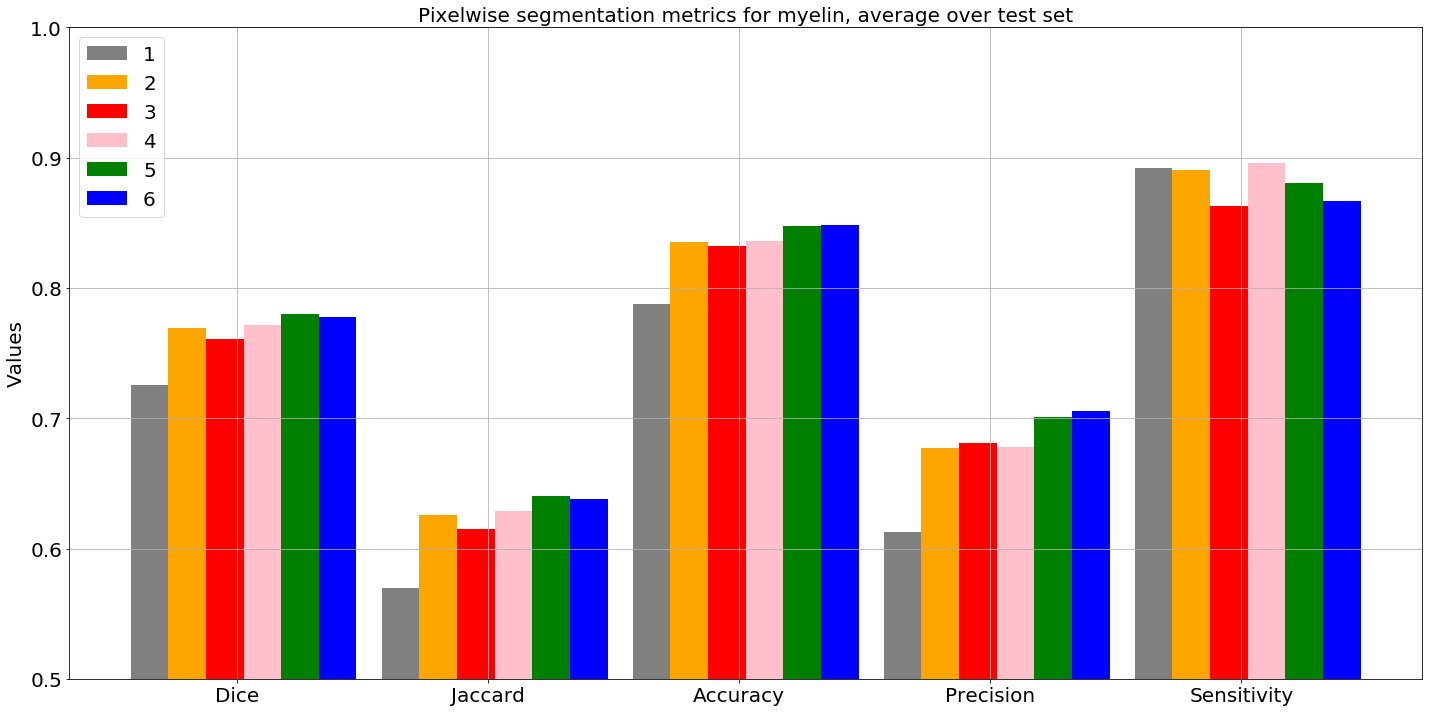

In [217]:
n_groups = 5
width=0.15
fig, ax = plt.subplots(figsize = (20, 10))
index = np.arange(n_groups)

for i in np.arange(1, 7, 1):
    plot = np.arange(-0.5, 1.8, width)
    color = "C" + str(i)
    color = ['black','grey', 'orange', 'red', 'pink', 'green', 'blue']
    rects1 = plt.bar(index + plot[i], score_global[i], width=width, color=color[i],label=i)
    

plt.ylabel('Values',fontsize=20)
plt.title('Pixelwise segmentation metrics for myelin, average over test set',fontsize=20)
plt.xticks(index, ('Dice', 'Jaccard', 'Accuracy', 'Precision', 'Sensitivity'),fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best',fontsize=20)
plt.grid(True)
plt.ylim(0.5, 1)

plt.tight_layout()
plt.show()

In [248]:
score_relative = score_global
score_relative

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.72568032, 0.56995376, 0.78768897, 0.61277086, 0.89242785],
       [0.76909885, 0.62585023, 0.83520961, 0.67749638, 0.89028026],
       [0.76100409, 0.61507264, 0.83242393, 0.68128874, 0.86300169],
       [0.77128657, 0.62875765, 0.8357048 , 0.67800586, 0.89605993],
       [0.7801624 , 0.6406344 , 0.84767795, 0.70102358, 0.88043843],
       [0.77761733, 0.6378243 , 0.84863019, 0.70554955, 0.86712853]])

In [249]:
score_relative = np.delete(score_relative, 0, 0)

In [252]:
diff = np.zeros((5, 5))
print(diff)
for j in range(0, 5):
    for i in range(0, 5):
        #print(i, j)
        diff[i, j] = score_relative[i+1, j] - score_relative[i, j] 
        #print(diff)
        
diff.shape

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


(5, 5)

In [253]:
diff

array([[ 0.04341854,  0.05589647,  0.04752064,  0.06472552, -0.00214759],
       [-0.00809477, -0.01077759, -0.00278568,  0.00379237, -0.02727857],
       [ 0.01028248,  0.01368501,  0.00328088, -0.00328288,  0.03305823],
       [ 0.00887583,  0.01187675,  0.01197314,  0.02301772, -0.01562149],
       [-0.00254507, -0.0028101 ,  0.00095224,  0.00452597, -0.0133099 ]])

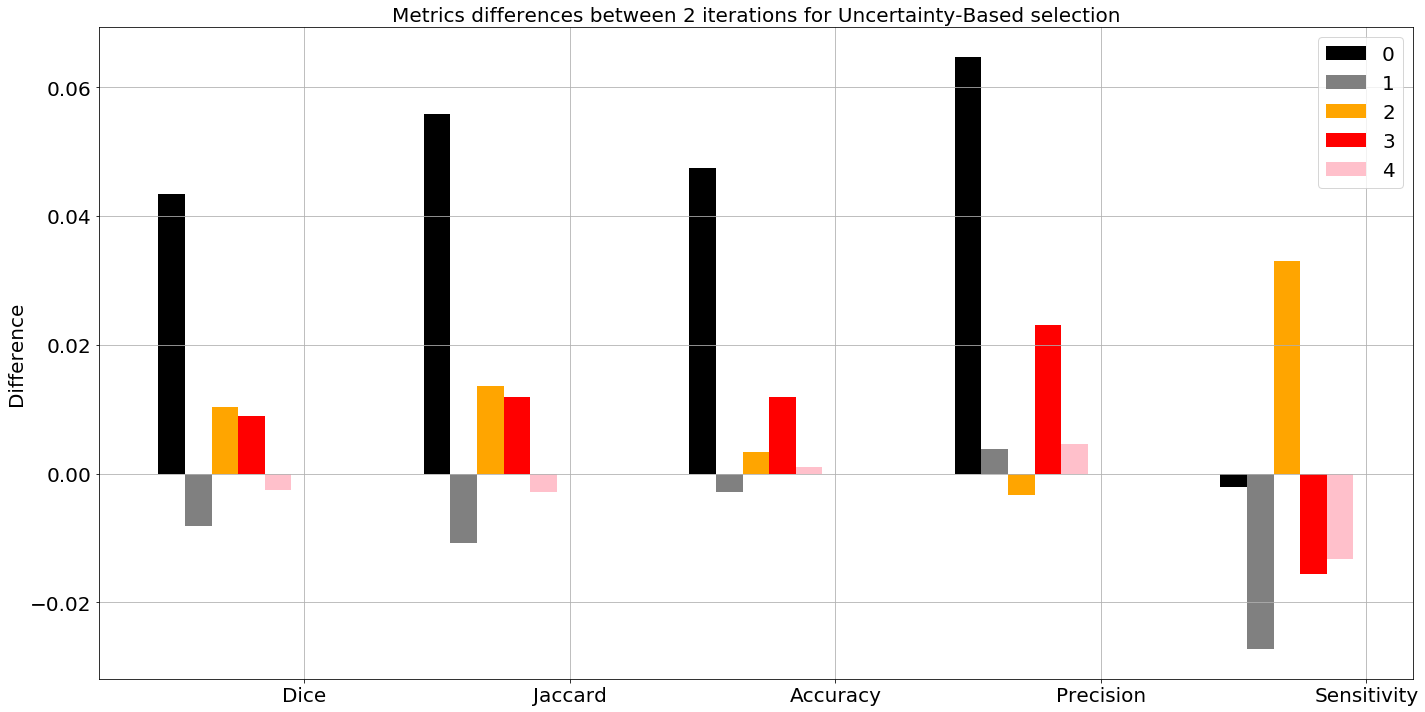

In [255]:
n_groups = 5
width=0.1
fig, ax = plt.subplots(figsize = (20, 10))
index = np.arange(n_groups)

for i in np.arange(0, 5):

    plot = np.arange(-0.5, 1.8, width)
    color = "C" + str(i)
    color = ['black','grey', 'orange', 'red', 'pink', 'blue']

    rects1 = plt.bar(index + plot[i], diff[i, :], width=width, color=color[i], label=i)
    
plt.ylabel('Difference',fontsize=20)
plt.title('Metrics differences between 2 iterations for Uncertainty-Based selection',fontsize=20)
plt.xticks(index, ('Dice', 'Jaccard', 'Accuracy', 'Precision', 'Sensitivity'),fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best',fontsize=20)
plt.grid(True)
#plt.ylim(-0.04, 0.1)

plt.tight_layout()
plt.show()

In [81]:
def read_history(history_path):
    txt_file = open(history_path,'r')
    text = txt_file.read()[2:-1].split(", '")

    loss = np.fromstring(text[0].split("[")[1][:-1], sep=',')
    val_dice_coef = np.fromstring(text[1].split("[")[1][:-1], sep=',')
    val_loss = np.fromstring(text[2].split("[")[1][:-1], sep=',')
    dice_coef = np.fromstring(text[3].split("[")[1][:-1], sep=',')
    return loss, val_dice_coef, val_loss, dice_coef


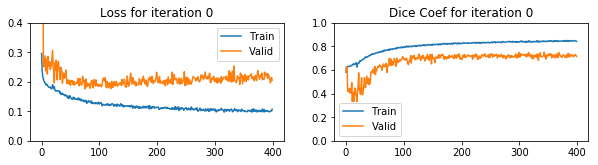

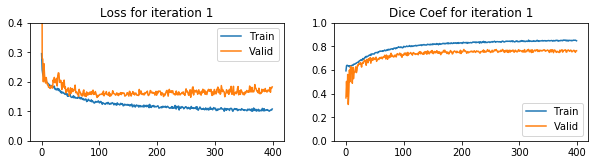

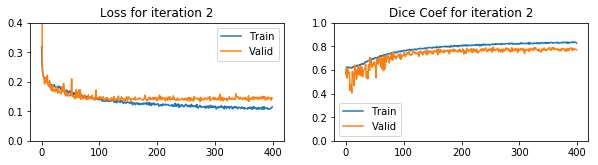

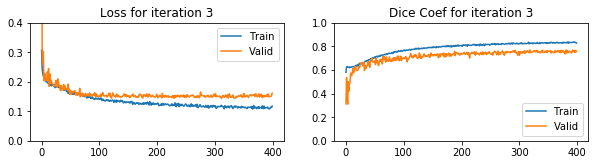

In [83]:
for i  in range(4):
    history_path = ['/home/malub_local/history/1004_0723_52_history_iter_0_.txt', 
                    "/home/malub_local/history/1004_0723_52_history_iter_1_.txt", 
                    "/home/malub_local/history/1004_0723_52_history_iter_2_.txt",
                   "/home/malub_local/history/1004_0723_52_history_iter_3_.txt"] 
    loss, val_dice_coef, val_loss, dice_coef = read_history(history_path[i])
    fig, ax = plt.subplots(figsize = (10, 10))
    plt.subplot(420 + 2*i + 1)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title("Loss for iteration " + str(i))
    plt.legend(["Train", "Valid"])
    plt.ylim(0, 0.4)
    plt.subplot(420 + 2*i + 2)
    plt.plot(dice_coef)
    plt.plot(val_dice_coef)
    plt.title("Dice Coef for iteration " + str(i))
    plt.legend(["Train", "Valid"])
    plt.ylim(0, 1)
    plt.show()

## Display segmentation for X_test 

In [256]:
threshold = 0.4
uncertain_test, uncertain_map_test, predictions_test = uncertainty_for_ranking(model, X_test)

Computing predictions for unlabelled data ...



In [257]:
predictions_test = np.asarray(predictions_test)
predictions_test.shape



(16, 512, 512)

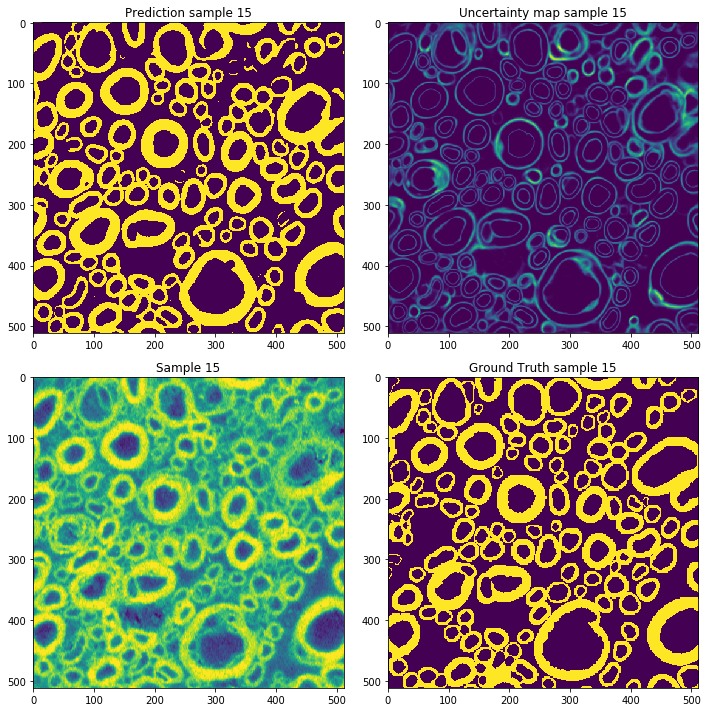

In [264]:
# Plot predictions and uncertainty map for 2 samples 
rand_int = random.randint(0, len(X_test)-1)
rand_int = 15
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(predictions_test[rand_int][:,:])
plt.title("Prediction sample " + str(rand_int))
plt.subplot(222)
plt.imshow(uncertain_map_test[rand_int])
plt.title("Uncertainty map sample "+ str(rand_int))
plt.subplot(223)
plt.imshow(X_test[rand_int][0,:,:])
plt.title("Sample "+ str(rand_int))
plt.subplot(224)
plt.imshow(y_test[rand_int][0,:,:])
plt.title("Ground Truth sample "+ str(rand_int))
plt.tight_layout()
plt.show()


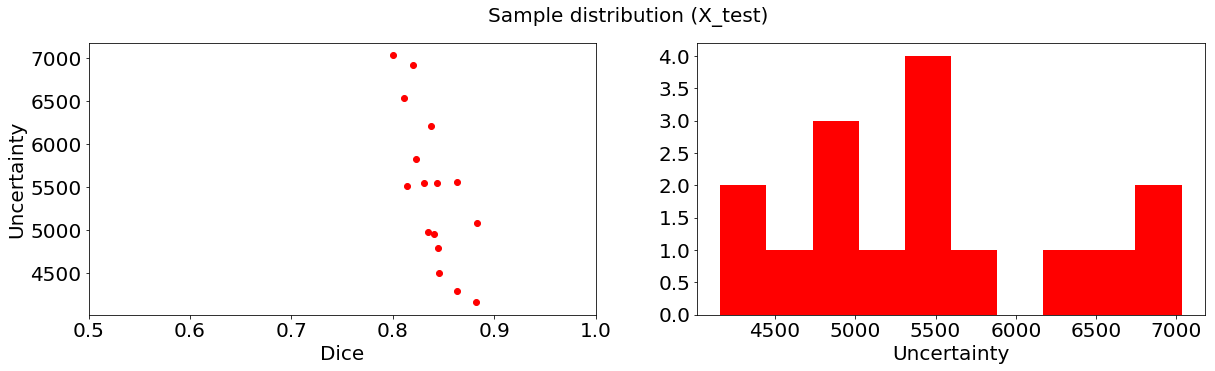

In [133]:
dice_plot = np.zeros(len(X_test))


for i in range(len(X_test)):
    dice_plot[i] = compute_dice_coef(y_test[i][0,:,:], predictions_test[i][:,:])
    

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.scatter(dice_plot, uncertain_test, color = "red")
plt.xlabel("Dice", fontsize=20)
plt.ylabel("Uncertainty", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0.5, 1)

plt.subplot(122)
plt.hist(uncertain_test.flatten(), 10, color = "red")
plt.xlabel("Uncertainty", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.suptitle("Sample distribution (X_test)", fontsize=20)
plt.show()

In [54]:
acc

array([0.87511444, 0.86398315, 0.88320541, 0.91376877, 0.88190079,
       0.85490799, 0.84724045, 0.91880035, 0.8605423 , 0.95693207,
       0.88864899, 0.89064789, 0.90397644, 0.84415817, 0.88794708,
       0.87411118])

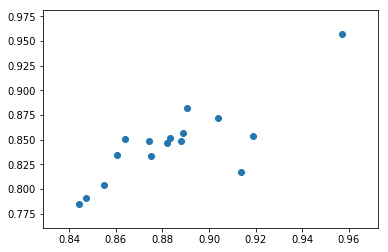

In [55]:
plt.scatter(acc, dice)

## Choose threshold 

In [84]:
# uncertainty computation
dice_coef_test = np.zeros(len(X_test))
dice = []

print("Computing log predictions ...\n")
predictions = predict(X_test, model)

for threshold in np.arange(0, 1, 0.05):
    dice_coef_test = np.zeros(len(X_test))
    for i in range(len(X_test)):
        sample = X_test[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        dice_coef_test[i] = compute_dice_coef(y_test[i][0], sample_prediction)
    dice.append(np.mean(dice_coef_test))


print(len(dice))
print("Done")


Computing log predictions ...

20
Done


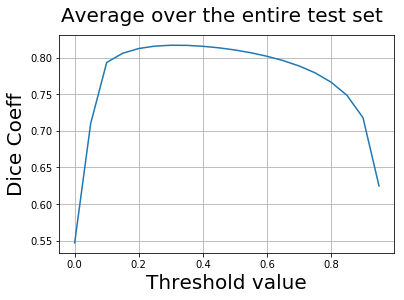

In [85]:
plt.plot(np.arange(0, 1, 0.05), dice )
plt.suptitle("Average over the entire test set", fontsize = 20)
plt.ylabel("Dice Coeff", fontsize = 20)
plt.xlabel("Threshold value", fontsize = 20)
plt.grid()
#plt.ylim(0.7, 0.75)
plt.show()

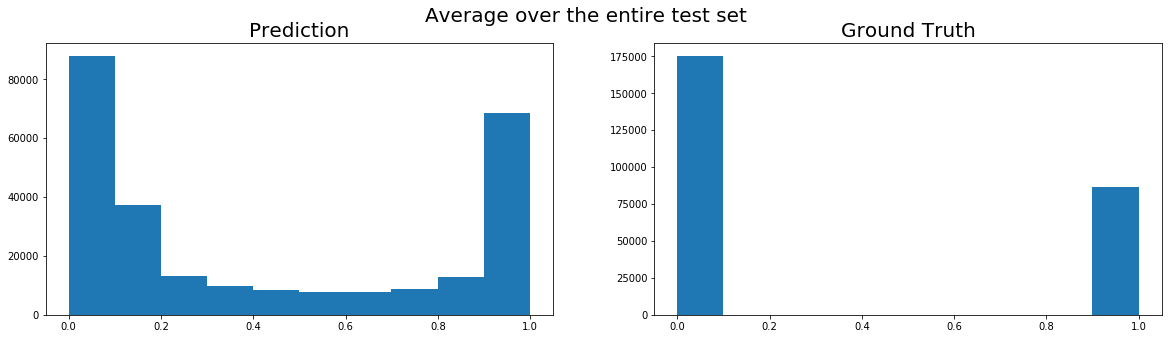

In [33]:
plt.figure(figsize=(20,5))
plt.suptitle("Average over the entire test set", fontsize = 20)
plt.subplot(121)
plt.hist(predictions[0].flatten())
plt.title("Prediction", fontsize = 20)
plt.subplot(122)
plt.hist(y_test[0].flatten())
plt.title("Ground Truth", fontsize = 20)
plt.show()

# Visuaize Data Augmentation

In [ ]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def visualize_data_augmentation(generator):
    batch1 = take(1, generator)
    max_images = 16
    grid_width = 8
    grid_height = 1
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
    for i in range(8):
        img = batch1[0][0][i, 0, :, :]
        mask = batch1[0][1][i, 0, :, :]
        ax = axs[ i % grid_width]
        ax.imshow(img, cmap="gray")
        ax.set_yticklabels([])
        ax.set_xticklabels([])


    fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 10))
    for i in range(8):
        img = batch1[0][0][i, 0, :, :]
        mask = batch1[0][1][i, 0, :, :]
        ax = axs[ i % grid_width]
        ax.imshow(mask, cmap="gray")
        ax.set_yticklabels([])
        ax.set_xticklabels([])

In [ ]:
visualize_data_augmentation(train_generator)